In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
from typing import Tuple
import os
from skimage.io import imread
from tqdm.notebook import tqdm
import random
from search_alg_visited_nodes import defeatist_search_vn, search_pruning_vn

In [2]:
with open("cifar-10/data_batch_1", "rb") as file:
    cifar = pickle.load(file, encoding="bytes")

In [59]:
text_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
cifar_labels = cifar[b'labels']

In [62]:
cifar_images = np.moveaxis(cifar[b'data'].reshape(10000, 3, 32, 32)/255., 1, -1)
cifar_images_gray = cifar_images.mean(axis=-1)
data_color = cifar_images[:30]
data_gray = cifar_images_gray[:30]
data_labels = list(map(lambda i: text_labels[i], cifar_labels[:30]))

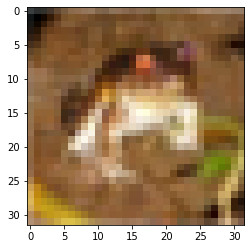

In [4]:
plt.imshow(cifar_images[0])

In [5]:
def select_samples_same_size(path, window_size, num_window):
    data = []
    for image_path in os.listdir(path):
        image = imread(os.path.join(path,image_path), as_gray=True)
        n, p = image.shape
        for i in range(0,num_window):
            x_min = random.randint(0,n-window_size[0])
            y_min = random.randint(0,p-window_size[1])
            im = image[x_min:x_min+window_size[0],y_min:y_min+window_size[1]]
            data.append(im)
    return np.array(data)

In [6]:
# window_size, num_window = [10,10], 5
# path = 'images'
# data = select_samples_same_size(path, window_size, num_window)

In [7]:
import cv2
def img_to_sig(arr):
    """Convert a 2D array to a signature for cv2.EMD"""
    
    # cv2.EMD requires single-precision, floating-point input
    channel = 1 if len(arr.shape) == 2 else arr.shape[2]
    sig = np.empty((arr.size, 4), dtype=np.float32)
    count = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for c in range(channel):
                if channel == 1:
                    sig[count] = np.array([arr[i,j], i, j, c])
                else:
                    sig[count] = np.array([arr[i,j,c], i, j, c])
                count += 1
    return sig

def img_channel_to_sig(arr):
    """Convert a 2D array with 3 channels (H,W,C) to a signature for cv2.EMD"""
    
    # cv2.EMD requires single-precision, floating-point input
    sig = np.empty((arr.size, 4), dtype=np.float32)
    count = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for c in range(arr.shape[2]):
                sig[count] = np.array([arr[i,j,c], i, j, c])
                count += 1
    return sig

In [8]:
%%time
sig1 = img_to_sig(data_gray[0])
sig2 = img_to_sig(data_gray[1])
dist = cv2.EMD(sig1, sig2, cv2.DIST_L1, lowerBound=0)[0]
print(dist)

1.6592062711715698
Wall time: 3.39 s


In [9]:
def all_distances(root, remaining_points):
    root_sig = img_to_sig(root)
    distances = []
    for point in remaining_points:
        point_sig = img_to_sig(point)
        distances.append(cv2.EMD(root_sig, point_sig, cv2.DIST_L2)[0])
    return np.array(distances)

In [11]:
root = data_gray[0]
points = np.array(data_gray[1:10])

In [14]:
%%time
distances = all_distances(root, points)

Wall time: 30.8 s


In [15]:
print(distances)

[0.49238414 2.96548724 0.16906708 3.34435463 1.49207616 0.91993988
 0.97946578 0.24924555 1.70746017]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
from typing import Tuple

colors = [name for name, color in mcolors.TABLEAU_COLORS.items()]


class MetricTree:
    def __init__(self, points: np.ndarray = None, pbar = None) -> None:
        self.root = None
        self.mu = None
        self.left = None
        self.min_left = None
        self.max_left = None
        self.right = None
        self.min_right = None
        self.max_right = None
        self.size = None
        if points is not None:
            self.build(points, pbar=pbar)

    def median_mu(
        self, points: np.ndarray, pivot: np.ndarray, distances, subset_size: int
    ) -> float:
        subset_idx = np.random.choice(len(points) - 1, size=subset_size, replace=False)
        # subset_points = points[subset_idx]
        distances_to_pivot = distances[subset_idx]
        return np.median(distances_to_pivot)

    def left_right_split(
        self, mu: float, points: np.ndarray, distances: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, float, float, float, float]:
        """
        Splits the points into left and right depending on their distance to root node.
        Points and distances are ordered by ascending distance to root node.

        Parameters
        ----------
        mu : float
            Threshold value for splitting the points
        points : np.ndarray
            Array of points to be splitted
        distances : np.ndarray
            Distances of the points to the root node

        Returns
        -------
        Tuple[np.ndarray, np.ndarray, float, float, float, float]
            Corresponds to the left and right subtree points with
            their min and max distances to the root node
        """
        if len(points) == 1:
            dist_to_pivot = distances[0]
            return points, None, dist_to_pivot, dist_to_pivot, None, None

        if np.all(distances) == 0:
            idx = int(len(distances)/2)
        else:
            idx = np.searchsorted(distances, mu, side="right")

        points_left = points[:idx]
        points_right = points[idx:]
        return (
            points_left,
            points_right,
            distances[0],
            distances[idx - 1],
            distances[idx],
            distances[-1],
        )

    def pivot_choice(self, points: np.ndarray) -> int:
        ## For the moment only random choice
        choice_idx = np.random.randint(len(points))
        return choice_idx

    def __repr__(self) -> str:
        return f"MetricTree: root={self.root}, size={self.size}"

    def __len__(self) -> int:
        return self.size

    def build(self, points: np.ndarray, subset_size: int = 10000, pbar=None):
        if pbar is not None:
            pbar.update(1)
        self.size = len(points)
        if len(points) == 0:
            return None
        if len(points) == 1:
            self.root = points[0]
            return self
        ## Selection of the pivot
        pivot_idx = self.pivot_choice(points)
        remaining_points = np.delete(points, pivot_idx, 0)
        self.root = points[pivot_idx]

        ## Compute distances
        #distances = cdist(self.root.reshape(1, *self.root.shape), remaining_points)[0]
        distances = all_distances(self.root, remaining_points)

        ## Sort the points by distance to the root
        sorted_indices = np.argsort(distances)
        distances = distances[sorted_indices]
        remaining_points = remaining_points[sorted_indices]

        ## Compute median on a subset of remaining points
        mu = self.median_mu(
            remaining_points,
            self.root,
            distances,
            min(len(remaining_points) - 1, subset_size),
        )
        self.mu = mu

        ## Split the points into left and right trees
        (
            points_left,
            points_right,
            self.min_left,
            self.max_left,
            self.min_right,
            self.max_right,
        ) = self.left_right_split(mu, remaining_points, distances)

        ## Build the left and right trees if needed
        if points_left is not None:
            self.left = MetricTree().build(points_left, pbar=pbar)
        if points_right is not None:
            self.right = MetricTree().build(points_right, pbar=pbar)
        return self

    def plot(self, color=None, fig=None, ax=None):
        if color is None:
            color = np.random.choice(colors)
        if fig is None:
            fig, ax = plt.subplots()

        ax.scatter(self.root[0], self.root[1], color=color)
        if self.left is not None:
            ax.plot(
                [self.root[0], self.left.root[0]],
                [self.root[1], self.left.root[1]],
                color=color,
            )
            self.left.plot(color, fig, ax)
        if self.right is not None:
            ax.plot(
                [self.root[0], self.right.root[0]],
                [self.root[1], self.right.root[1]],
                color=color,
            )
            self.right.plot(color, fig, ax)


In [23]:
pbar = tqdm(total=len(data_gray))
tree = MetricTree(data_gray, pbar=pbar)
pbar.close()

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\33611\Miniconda3\envs\fgmda\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\33611\Miniconda3\envs\fgmda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [204]:
choice = np.random.randint(len(cifar_images_gray))
query = cifar_images_gray[choice]
print(choice)

1064


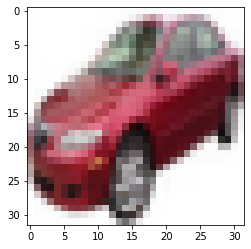

In [205]:
plt.imshow(query, cmap="gray")
plt.imshow(cifar_images[choice], cmap="gray")

In [131]:
def EMD(point1, point2):
    sig1 = img_to_sig(point1)
    sig2 = img_to_sig(point2)
    #print(point1)
    #print(sig1)
    return cv2.EMD(sig1, sig2, cv2.DIST_L2)[0]

In [27]:
def isin_dilated_interval(value, min, max, dilation):
    lower_bound = value > (min - dilation)
    upper_bound = value < (max + dilation)
    return lower_bound and upper_bound

def search_pruning_vn(
    metric_tree: MetricTree,
    query_point: np.ndarray,
    min_dist: float = np.inf,
    result: np.ndarray = None,
    visited_nodes: int = 0,
):
    if metric_tree.size == 1:
        visited_nodes += 1
        current_dist = EMD(query_point, metric_tree.root)
        if current_dist < min_dist:
            return metric_tree.root, current_dist, visited_nodes
        else:
            return result, min_dist, visited_nodes
    else:
        left = False
        current_dist = EMD(query_point, metric_tree.root)
        if current_dist < min_dist:
            result = metric_tree.root
            min_dist = current_dist

        ## Verifying that the left (resp. right) tree is not empty
        ## so min and max are defined
        if (metric_tree.left is not None) and isin_dilated_interval(
            current_dist, metric_tree.min_left, metric_tree.max_left, min_dist
        ):
            left = True
            visited_nodes += 1
            result, min_dist, visited_nodes = search_pruning_vn(
                metric_tree.left, query_point, min_dist, result, visited_nodes
            )

        if (metric_tree.right is not None) and isin_dilated_interval(
            current_dist, metric_tree.min_right, metric_tree.max_right, min_dist
        ):
            if not left:
                visited_nodes += 1
            result, min_dist, visited_nodes = search_pruning_vn(
                metric_tree.right, query_point, min_dist, result, visited_nodes
            )

        return result, min_dist, visited_nodes

In [206]:
%%time
nn, dist, vn = search_pruning_vn(tree, query)
print(vn)

4
Wall time: 24.6 s


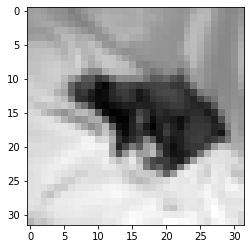

In [207]:
plt.imshow(nn, cmap="gray")

(-0.5, 31.5, 31.5, -0.5)

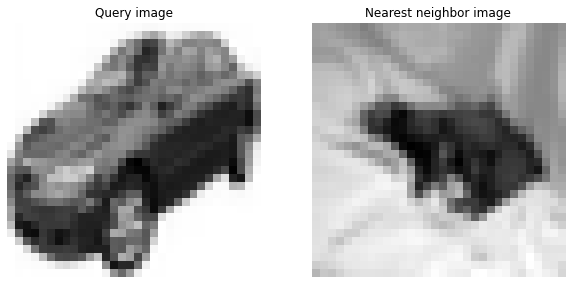

In [208]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
ax1.imshow(query, cmap="gray")
ax1.set_title("Query image")
ax2.imshow(nn, cmap="gray")
ax2.set_title("Nearest neighbor image")
ax1.axis("off")
ax2.axis("off")

In [31]:
def defeatist_search_vn(
    metric_tree: MetricTree,
    query_point: np.ndarray,
    min_dist: float = np.inf,
    result: np.ndarray = None,
    visited_nodes: int = 0):

    if metric_tree.size == 1:
        visited_nodes += 1
        current_dist = EMD(query_point, metric_tree.root)
        if current_dist < min_dist:
            return metric_tree.root, current_dist, visited_nodes
        else:
            return result, min_dist, visited_nodes

    else:

        current_dist = EMD(query_point, metric_tree.root)
        if (metric_tree.max_left is not None) and (metric_tree.min_right is not None):
            mu = (metric_tree.max_left + metric_tree.min_right)/2
        else:
            mu = metric_tree.max_left

        if current_dist < min_dist:
            min_dist = current_dist
            result = metric_tree.root

        if (current_dist < mu) and (metric_tree.left is not None):
            visited_nodes += 1
            result, min_dist, visited_nodes = defeatist_search_vn(metric_tree.left, query_point, min_dist, result, visited_nodes)

        elif (metric_tree.right is not None):
            visited_nodes += 1
            result, min_dist, visited_nodes = defeatist_search_vn(metric_tree.right, query_point, min_dist, result, visited_nodes)

        return result, min_dist, visited_nodes

In [102]:
%%time
nn, dist, vn = defeatist_search_vn(tree, query)
print(vn)

5
Wall time: 18.3 s


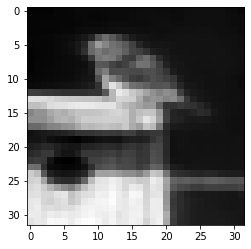

In [103]:
plt.imshow(nn, cmap="gray")

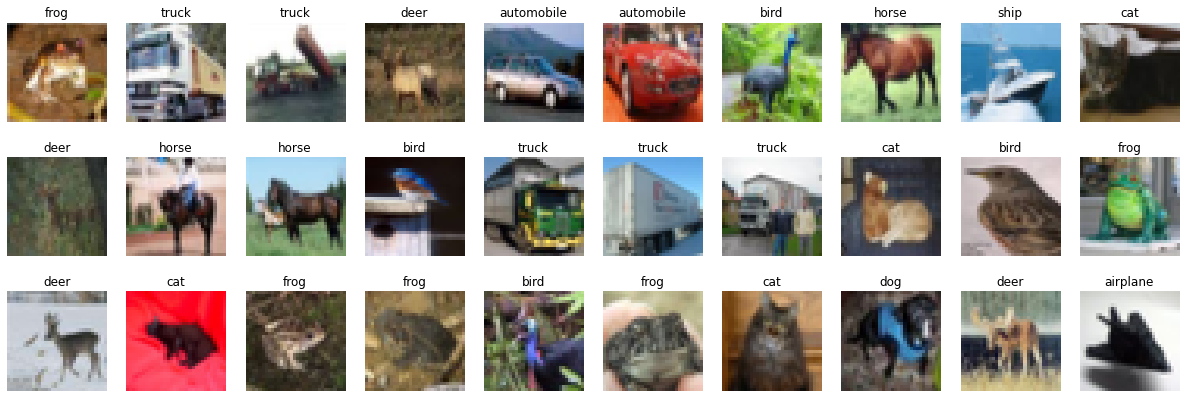

In [115]:
fig, ax = plt.subplots(3,10, figsize=(21,7))
for i, image in enumerate(data_color):
    ax[i//10, i%10].imshow(image, cmap="gray")
    ax[i//10, i%10].title.set_text(data_labels[i])
    ax[i//10, i%10].axis("off")